## Gempy to pyGIMLi - 3D 
### Example from transform2021 Hackathon 

The purpose of this notebook is to show the bridge between Gempy - pyGIMLi using subsurface objects. These new functions are in the pyGIMLi library under meshtools and help support the [subsuface library](https://softwareunderground.github.io/subsurface/index.html). This example has helped extend pyGIMLi 3D functionality. Right now `mt.fromSubsurface` supports unstructured and structured grids. This examples goes through different gempy models converted to pyGIMLi meshes.

**Note** : Create and activate environment for this notebook "absub"

Import all packages that are needed 

In [2]:
import shutil
import pandas as pd
import numpy as np
import subsurface as ss
import pooch
import gempy as gp
import xarray 
import matplotlib.pyplot as plt
import subsurface.reader.read_netcdf
import pygimli as pg
import pygimli.meshtools as mt

No module named 'osgeo'


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


### Load Gempy Model 

Loading the gempy model that was built from well data (see [Tutorial welly and subsurface](https://softwareunderground.github.io/subsurface/examples/tutorials/reading_well_data.html#sphx-glr-examples-tutorials-reading-well-data-py) )

In [3]:
model_files_2 = pooch.retrieve(
    url="https://github.com/cgre-aachen/gempy_data/raw/master/data/gempy_models/Kim.zip",
    known_hash="f530a88351ed0e38673c6937161c59a2f69df92202e14c1e5d5729ed5d72a323",
    processor=pooch.Unzip()
)

### Structured Grids 

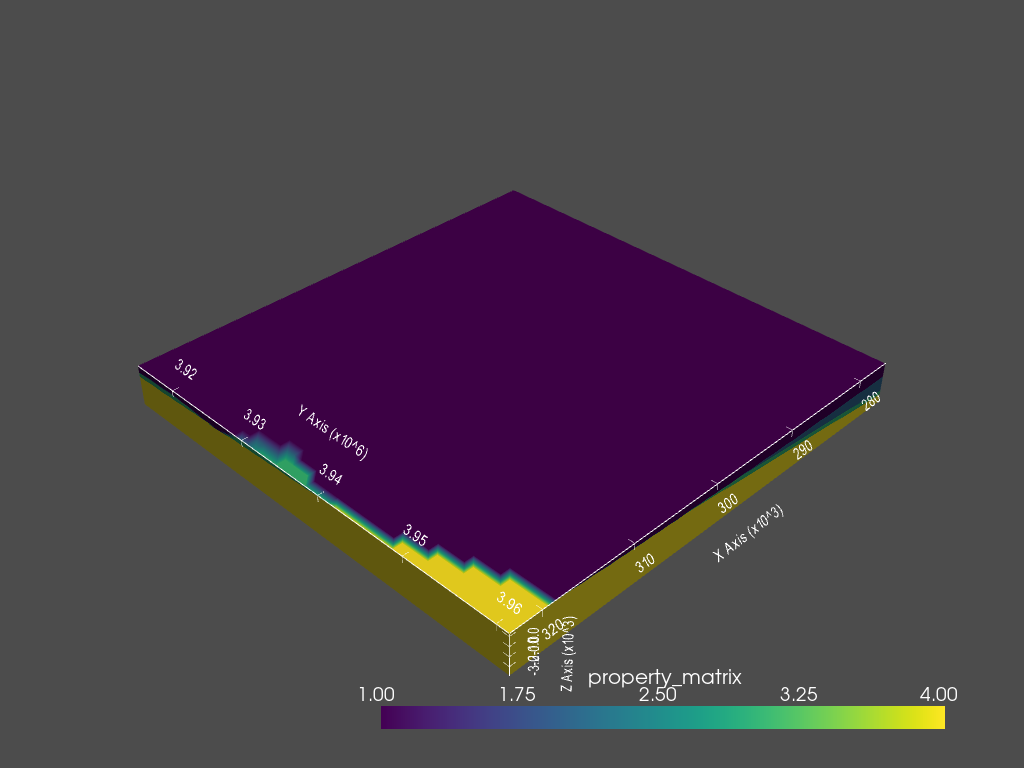

In [4]:
fname, = [i for i in model_files_2 if "regular_grid.nc" in i]
gempy_struct = ss.reader.read_netcdf.read_struct(fname)
regular_grid = ss.StructuredGrid(gempy_struct)

pyvista_mesh = ss.visualization.to_pyvista_grid(regular_grid,
                                                data_set_name='property_matrix',
                                                attribute_slice={'Properties': 'id'}
                                                )

ss.visualization.pv_plot([pyvista_mesh])

### pyGIMLi to subsurface 

In [5]:
pgmesh = mt.fromSubsurface(gempy_struct, order='F') #pass in structured subsurface object and `np.flatten` order ( C or F )

Now we go to the pyGIMLi world ! 

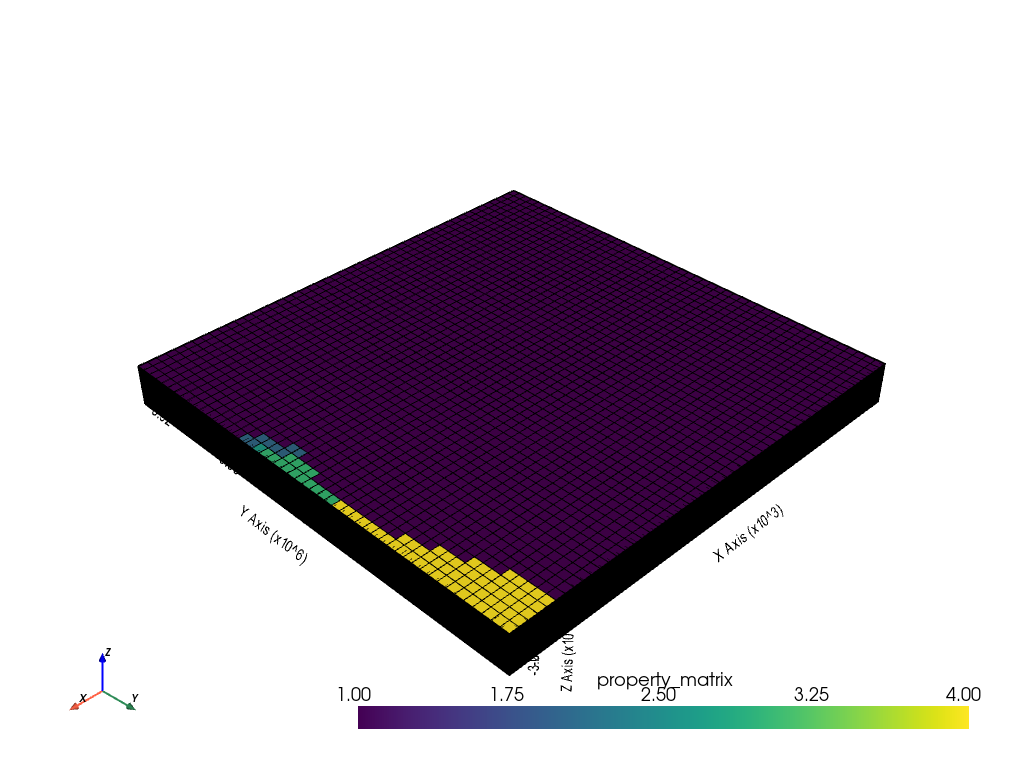

(<pyvista.plotting.plotting.Plotter at 0x7feb3960a9a0>, None)

In [23]:
pg.show(pgmesh, pgmesh['property_matrix'], label = 'property_matrix')

In [21]:
print(pgmesh)

Mesh: Nodes: 132651 Cells: 125000 Boundaries: 382500
Mesh contains data: block_matrix[0,...,2), fault_mask[0,...,2), mask_matrix[0,...,2), property_matrix, scalar_field_matrix[0,...,2)


### Unstructured Grids 

In the case of unstructured objects, we read in the model mesh `mesh.nc` and use `ss.TriSurf` to grid the subsurface object. 
Here we read in a surface and convert it to pyGIMLi mesh 


In [29]:
data = ss.reader.read_netcdf.read_unstruct(data_path + '/meshes.nc')
ssGmpy = ss.TriSurf(data)
pg.info(ssGmpy.mesh)

pgmeshu = mt.fromSubsurface(ssGmpy, order='F')

/opt/anaconda3/envs/absub/lib/python3.8/site-packages/subsurface/reader/read_netcdf.py:15: UserWarning: Trying loading legacy files.
  warnings.warn("Trying loading legacy files.")
23/04/21 - 12:44:04 - pyGIMLi - INFO - <xarray.Dataset>
Dimensions:           (XYZ: 3, attribute: 1, cell: 17079, cell_attr: 1, nodes: 3, points: 8742, points_attribute: 0, vertex_attr: 0)
Coordinates:
  * points            (points) int64 0 1 2 3 4 5 ... 8737 8738 8739 8740 8741
  * XYZ               (XYZ) object 'X' 'Y' 'Z'
    cell_             (cell) int64 0 1 2 3 4 5 ... 17074 17075 17076 17077 17078
  * cell_attr         (cell_attr) object 'id'
  * vertex_attr       (vertex_attr) int64 
  * attribute         (attribute) object 'id'
  * points_attribute  (points_attribute) int64 
Dimensions without coordinates: cell, nodes
Data variables:
    vertex            (points, XYZ) float64 3.232e+07 5.691e+06 ... 1.945e+03
    cells             (cell, nodes) int32 2 1 0 1 2 ... 8738 8624 8624 8738 8740
    cell_

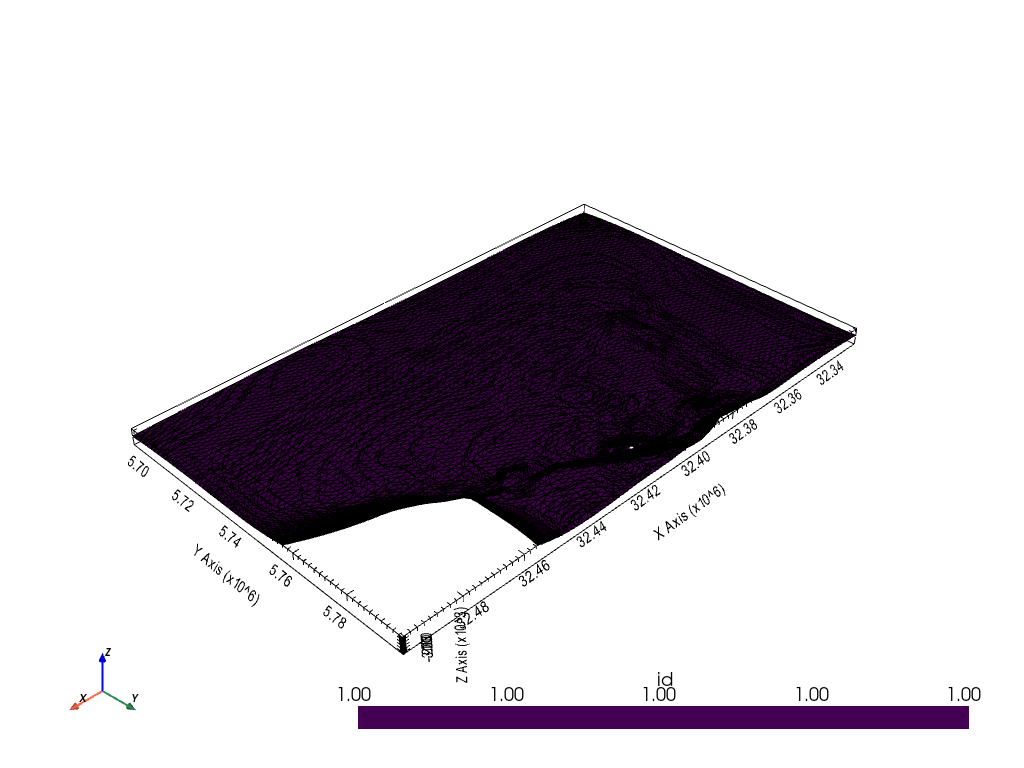

(<pyvista.plotting.plotting.Plotter at 0x7feb69148af0>, None)

In [34]:
pg.show(pgmeshu)

### pyGIMLi toSubsurface 

pyGIMLi now also has  `mt.toSubsurface` to transfer pyGIMLi meshes into subsurface objects. For now, it only outputs unstructured elements.

In [37]:
ssGmpy = mt.toSubsurface(pgmeshu)
pg.info(ssGmpy.mesh)
type(ssGmpy)

23/04/21 - 12:50:15 - pyGIMLi - INFO - <xarray.Dataset>
Dimensions:       (XYZ: 3, cell: 17079, cell_attr: 1, nodes: 3, points: 8742, vertex_attr: 0)
Coordinates:
  * points        (points) int64 0 1 2 3 4 5 6 ... 8736 8737 8738 8739 8740 8741
  * XYZ           (XYZ) <U1 'X' 'Y' 'Z'
  * cell_attr     (cell_attr) object 'id'
  * vertex_attr   (vertex_attr) int64 
    cell_         (cell) int64 0 1 2 3 4 5 ... 17074 17075 17076 17077 17078
Dimensions without coordinates: cell, nodes
Data variables:
    vertex        (points, XYZ) float64 3.232e+07 5.691e+06 ... 1.945e+03
    cells         (cell, nodes) int64 2 1 0 1 2 3 ... 8738 8624 8624 8738 8740
    cell_attrs    (cell, cell_attr) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    vertex_attrs  (points, vertex_attr) float64 


subsurface.structs.unstructured_elements.TriSurf

### Gravity Forward Operator Test 

We will use another Gempy model to simulate the gravity response in the pyGIMLi mesh

The following cell may take some time. We are building the model from an example Gempy data set 

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                         values
range              2926.174978
$C_o$            203869.047619
drift equations         [3, 3]


/opt/anaconda3/envs/absub/lib/python3.8/site-packages/gempy-2.2.8-py3.8.egg/gempy/plot/plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


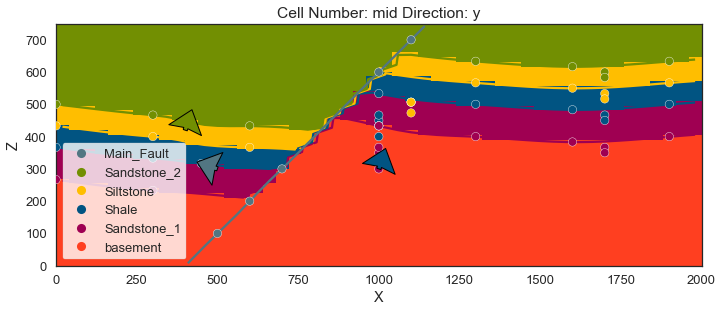

In [38]:
geo_model = gp.create_model('Tutorial_ch1_1_Basics')

data_path = 'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/'

# Importing the data from CSV-files and setting extent and resolution
gp.init_data(geo_model, [0, 2000., 0, 2000., 0, 750.], [50, 50, 50],
             path_o=data_path + "/data/input_data/getting_started/"
                                "simple_fault_model_orientations.csv",
             path_i=data_path + "/data/input_data/getting_started/"
                                "simple_fault_model_points.csv",
             default_values=True)

gp.map_stack_to_surfaces(geo_model,
                         {"Fault_Series": 'Main_Fault',
                          "Strat_Series": ('Sandstone_2', 'Siltstone',
                                           'Shale', 'Sandstone_1', 'basement')},
                         remove_unused_series=True)
geo_model.set_is_fault(['Fault_Series'])


#Compiling THEANO functions
#geo_model.update_to_interpolator()
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_run',
                    )
 
model = gp.compute_model(geo_model, to_subsurface=True) #Compute Model
gp.plot_2d(geo_model)

Now we convert the Gempy model into pyGIMLi mesh and also export a vtk file that allows us to view and further analyze using a 3D plotting software

In [40]:
gempymesh = model.s_regular_grid
pgmesh_new = mt.fromSubsurface(gempymesh, order='F')
pgmesh_new.exportVTK('pgmesh_vtk')

In [41]:
type(pgmesh_new)

pgcore._pygimli_.Mesh

Now that we are in the pyGIMLi world, we assign density values to the layers from Gempy Model 

[2. 3. 4. 5. 6.]


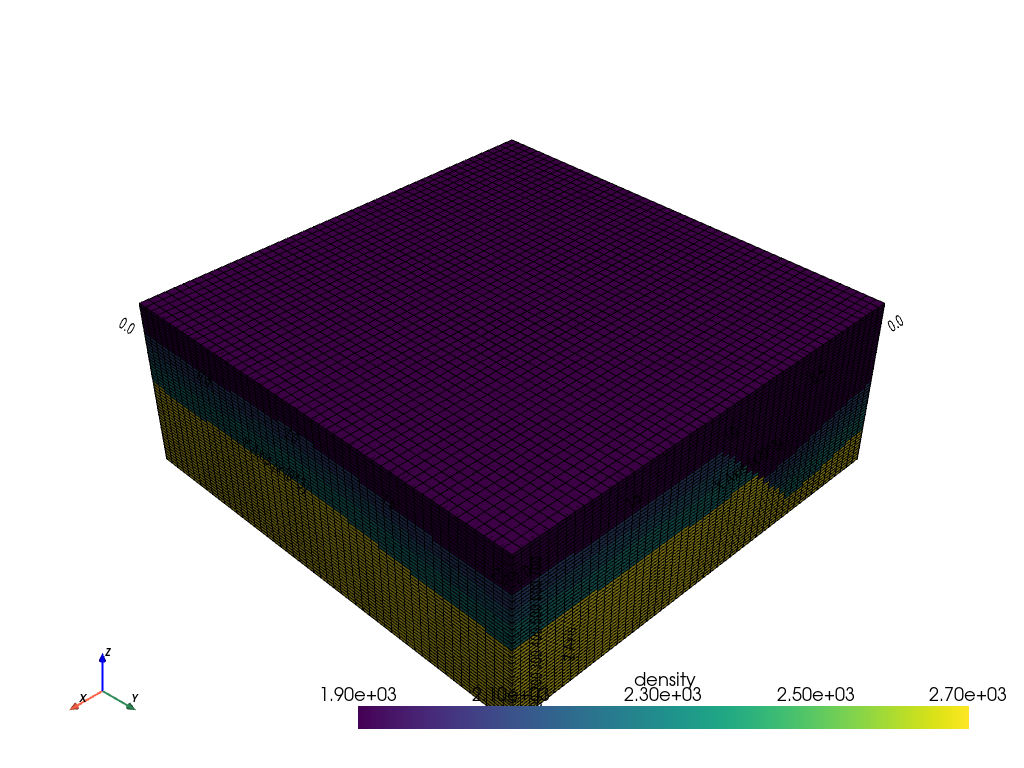

(<pyvista.plotting.plotting.Plotter at 0x7feb6986c2b0>, None)

In [89]:
pvec = pgmesh_new['property_matrix']
pvec = np.around(pvec) #Round Float values from property matrix
dens = np.zeros(pvec.shape[0])
(unique, counts) = np.unique(pvec, return_counts=True)
layers = np.asarray(unique)
print(layers)

## Assign values to new dens vec 
dens[pvec==6] = 2700
dens[pvec==5] = 2300
dens[pvec==4] = 2200
dens[pvec==3] = 2100
dens[pvec==2] = 1900

density = pg.solver.cellValues(pgmesh_new, dens)
pg.show(pgmesh_new, density, label='density')

We need to extend the 3D grid to avoid edge effects when calculating the gravity potential. We do this by using the handy function : `pg.meshtools.appendBoundaryGrid` . We extend the boundaries to 0 and interpolate our densities value to the larger mesh. 

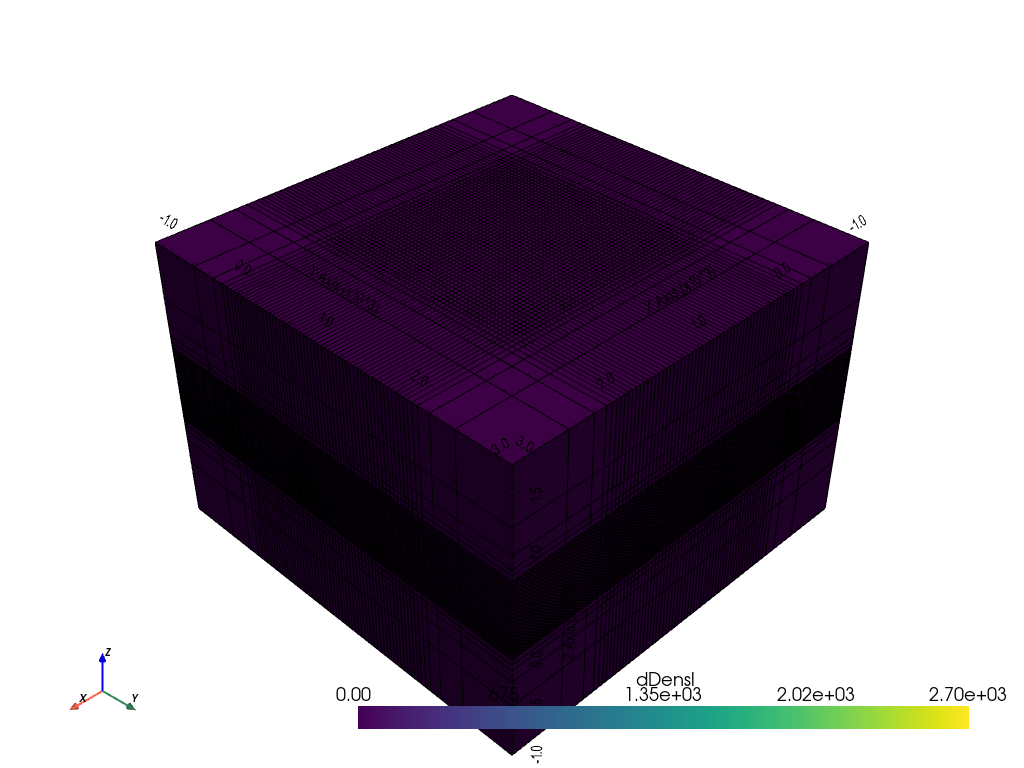

(<pyvista.plotting.plotting.Plotter at 0x7feb7d2c3670>, None)

In [90]:
l = np.geomspace(50, 1000, num=5) #We extend using logarithmic values to have bigger cells at the further boundaries.
ml = pg.meshtools.appendBoundaryGrid(pgmesh_new, xbound=l, ybound=l, zbound=l, 
                                     isSubSurface=False, verbose=True)
                                     
dDensL = pg.interpolate(pgmesh_new, density, ml.cellCenters(), fallback=0)

pg.show(ml, dDensL, label='dDensl') # change opacity here doesn't work :( 

No we calculate the gravity potential. The gravitational potential of a spatially distributed density anomaly can be obtained using a finite-element solution of the following equation:

$$ \nabla^{2} \phi=-4 \pi G \rho(x, y, z) $$

The gravitational anomaly is then given by:

$$ g(x, y, z)=-\nabla \phi $$ 

The following cell may take some time : 

In [91]:
pg.tic()
phi = 4. * np.pi * pg.physics.constants.GmGal * pg.solver.solve(ml, a=1, f=dDensL, bc={'Dirichlet':{'*': 0.0}})
grad = -pg.solver.grad(ml, phi)
pg.toc()
#pg.show(ml, phi, label='phi')

Elapsed time is 1 minute and 46.17 seconds.


We place the sensors near the area of interest from the initial Gempy model and look at the G_z 

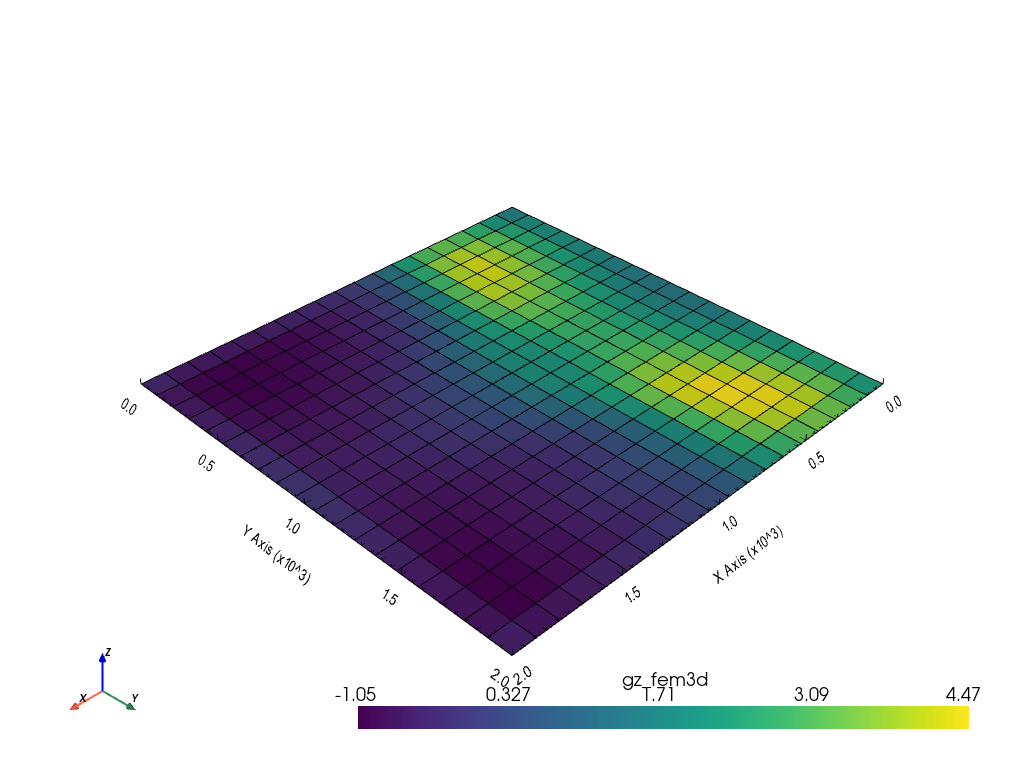

(<pyvista.plotting.plotting.Plotter at 0x7feb8ae8a700>, None)

In [88]:
height = 350
n = np.linspace(0, 2000, 20)
mesh2D = pg.createGrid(n,n)
mesh3D = pg.createGrid(n, n, np.zeros(len(n))+height)    
gz_fem3d = pg.interpolate(ml, grad[:,2], destPos=mesh3D.cellCenters())
pg.show(mesh3D,gz_fem3d, label='gz_fem3d')